# NaLIR: Python Implementation Notebook -  Tutorial SBDD 2020

### Autores: Altigran da Silva, Brandell Ferreira, Lucas Citolin e Paulo Martins

Nesse Notebook mostraremos a implementa de uma Interface de Linguage Natural para Banco de Dados. Será mostrado a arquitetura geral do Sistema, e para cada módulo, será listado o que recebem como entrada, e o que geram como saída. Além disso, mostraremos detalhes de implementação que são interessantes em cada módulo. Ao final, mostraremos alguns exemplos de consultas que o NaLIR consegue obter uma SQL válida. É importante dizer que apenas portamos o código para Python, o código original em Java se encontra neste [repositório](https://github.com/umich-dbgroup/NaLIR).

<a id='arquitetura_geral'></a>
## Arquitetura Geral

O NaLIR é uma Interface de Lingaugem Natural que utiliza uma estrutura derivada do Parser de Dependência para traduzir as consultas de linguagem natural para uma linguagem estruturada de consulta de banco de dados (SQL). Além de utilizar o Parser de Dependência, o NaLIR também utiliza interações com o usuário para corrigir possíveis erros na estrutura da árvore de Dependência e nos mapeamentos padrões escolhidos das palavras da consulta para elementos de Banco de Dados.

Como podemos ver na figura Abaixo, A arquitetura do NaLIRpossui **5** Componentes: **Dependecy Parser** , **Query Node Mapper**, **Query Tree Strucutre Adjustor**, **Query Translator** e **Interative Comunicator**. O **Depency Parser** recebe  a consulta do usuário,e repassa a entrada para o parser de Dependêcia de Stanford. Após retirar gerar a Árvore de Depência, o **Query Node Mapper** é reponsável por mapear os nós da árvore de dependencia para elementos da estrutura de uma SQL.

Após a escolha dos mapementos, o **Interactive Communicatior** entra em ação pela primeira vez, fornecendo para o usuário os candidatos encontrados pelo **Query Node Mapper**. Após o usuário escolher os mapeamentos para cada Nó, **Query Tree structure Adjustor** executa um algoritmo para modificar a estrutura da Árvore para que a conversão para uma consulta SQL seja facilitada. Tais modificações são feitas seguindo uma gramática. A saída dessa etapa é uma lista de árvores, ordenadas por uma pontuação que indica o quão correta está a árvore e a relação entre os elementos do banco de dados que os nós referenciam.

Pela Segunda vez, o **Interactive Comunicator** entra em ação, para que o usuário escolha qual árvore será escolhida pelo usuario. Após isso, **Query Tree Structure Adjustor** insere nós na árvore selecionada pelo usuário com o intuito de retirar possíveis elipses da consulta. Pela última vez **Interactive Commnunicator** mostra ao usuário as inserções feitas. Após a ação do usuário, a árvore de consulta é repassada para o **Query Tree Translator** que efetivamente converte a árvore para uma SQL válida.

Na nossa implementação, **não portamos o Interactive Communicator**, assim o único fluxo possível é aquele em que o **NaLIR utiliza todos os mapeamentos padrões** para resolver a consulta.

![Arquitetura Geral](imgs/OverallDiagram.png)

É importante salientar que apesar de apenas quatro módulos estarem presentes na arquitetura do NaLIR, alguns módulos auxiliares foram implementados,como o que gerencia o acesso ao Banco de Dados. Apesar deste módulo estar presente nas entrelinhas do fluxo na Arquitetura mostrada acima, foi preciso implementá-lo para que fosse possível a construção do Sistema.

## Configuração do Cliente

In [ ]:
from nalir import *

O primeiro passo é **instanciar** o objeto de configuração responsável por carregar os arquivos requeridos para que a execução do Nalir possa ser feita. A configuração é feita a partir de um objeto JSON. As propriedades desse objeto JSON devem ser:

| Propriedade | Tipo | Descrição |
| :-- | :-: | :-- | 
| `connection` | Object | Armazena as configurações de conexão com o Banco de dados |
| `connection.host`|  String | Host para a conexão com o Banco de Dados |
| `connection.password`| String | Senha para conectar com o Banco de Dados |
| `connection.user` | String | Usuario de Banco de Dados|
| `connection.database` | String | Nome do Banco de Dados utilizado |
| `logginMode` | String | Nivel de Login da Aplicação|
| `zfiles_path`| String | Diretório onde se encontra os arquivos de configuração do NaLIR|
| `jars_path` | String | Diretório onde se encontra os jars necessários para a execução do NaLIR |

In [3]:
config_json_text = '''{
    "connection":{
        "host": "localhost",
        "password":"paulo",
        "user":"paulo",
        "database":"mas"
    },
    "loggingMode": "ERROR",
    "zfiles_path":"/home/pr3martins/Desktop/zfiles",
    "jars_path":"/home/pr3martins/nalir-sbbd/jars"
}
'''
config = ConfigHandler(reset=True,config_json_text=config_json_text)

Após colocar todas as configurações necessárias e criar o objeto, é preciso criar uma instância do módulo que gerencia o acesso ao Banco de Dados.

In [3]:
rdbms = RDBMS(config)

Para exemplificar passo a passo como os módulos do NaLIR interagem com a consulta, utilizaremos a consulta ''return me the authors who have papers in VLDB conference before 2002 after 1995.''.

In [4]:
query_line='return me the authors who have papers in VLDB conference before 2002 after 1995.'
query = Query(query_line,rdbms.schema_graph)

## Stanford Dependency Parser

Na inicialização da classe `StanfordParser` executamos 3 passos para transformar a consulta em uma árvore de dependência. Cada passo é representado por uma função no código a seguir:

``` python
     def __init__(self,query,config):
        
        #....
        
        self.parse(query)
        self.build_tree(query)
        self.fix_conj(query)
        
        #....
```

A função `parse(query)` executa o parser de dependencia na consulta recebida, enquanto as outras `build_tree` e `fix_conj` são responsáveis por adaptar a estrutura para uma estrutura `ParseTree` definida dentro do pacote. A seguir mostramos como a função `build_tree` constrói a Árvore de Dependência a partir das dependencias extraídas pelo Parser de Stanford.

``` python
    def build_tree(self,query):
        query.parse_tree = ParseTree()
        done_list = [False] * len(query.tree_table)
        i = 0

        for tree_table_item in query.tree_table:
            if tree_table_item[PARENT_IDX] == 0:
                done_list[i] = True
                query.parse_tree.build_node(tree_table_item)
            i+=1

        finished = False
        while not finished:
            i = 0
            for i in range(len(query.tree_table)):
                if not done_list[i]:
                    if query.parse_tree.build_node(query.tree_table[i]):
                        done_list[i] = True
                        break


            finished = True
            for done_list_item in done_list:
                if not done_list_item:
                    finished = False
                    break

```

A tabela `query.tree_table` é criada em `parse(query)`. `fix_conj()` corrige relações de conjunção (quando duas palavras estão conectadas por "e" ou "ou"). Abaixo temos o exemplo da saída do módulo. 

In [5]:
StanfordParser(query,config)
query.parse_tree

(1)ROOT
    (2)return
        (3)me
        (4)authors
            (5)the
            (6)have
                (7)who
                (8)papers
                    (9)conference
                        (10)in
                        (11)VLDB
                        (12)2002
                            (13)before
                (14)1995
                    (15)after

**Important Note**: The graph vizualitation requires the program [Graphviz](https://graphviz.org/) (alongside with the graphviz python package) to be installed.

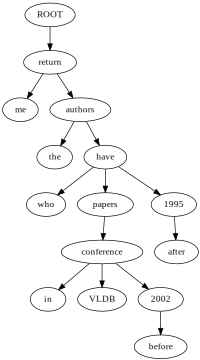

In [6]:
query.parse_tree.show()

## Node Mapper

Como dito em [Arquitetura Geral](#arquitetura_geral), o módulo de **Query Tree Node Maper**, que no código é repesentado por `NodeMapper`, possui a função de mapear os nós da árvore de dependência para os elementos da estrutura SQL. Os tipos de nós, são: 


<a id="tipo_no"></a>

| Tipo de Nó |Componente SQL Correspondente |
| :-- | :-- |
| Select Node (SN) |palavra reservada SQL : SELECT |
| Operator Node (ON) | operadores ( !=, >,<,=,  contains) |
| Function Node (FN) | Funções de Agregação (AVG) |
| Name Node (NN) | Nome de Relação ou de Atributo |
| Value Node (VN) | Valor de um determinado atributo |
| Quantifier Node (QN) | Palavras como ALL, ANY, EACH |
| Logic Node (LN) | Operadores Booleanos (AND, OR, NOT) |

Excluindo os Nós **Name** e **Value** nodes, todos os outros são definidos a partir de um arquivo xml. Esse arquivo se encontra dentro do diretório `zfiles`, como o nome de `tokens.xml` e possui o seguinte formato: 
``` xml
<types>
   <!-- Command Token, verb -->
   <CMT_V>
      <phrase>
         tell
         <example>Tell me all the books published in year 1993.</example>
      </phrase>
      <phrase>
         give
         <example>Give me all the books published in year 1993.</example>
      </phrase>
      <phrase>
         return
         <example>Return all the books published in year 1993.</example>
      </phrase>
   </CMT_V>
   <!-- Function Token, adjective -->
   <FT>
      <phrase>
         minimum
         <function>min</function>
         <example>Find the books with the minimum price.</example>
      </phrase>
      <phrase>
         most
         <function>max</function>
      </phrase>
      <phrase>
         biggest
         <function>max</function>
      </phrase>
      <phrase>
         least
         <function>min</function>
      </phrase>
   </FT>
   <!-- Operator Token, adj -->
   <OT>
      <phrase>
         earlier
         <operator>&lt;</operator>
         <example>Find all the books of Ayn Rand, where the year of each book is earlier than the year of "Fountain Head".</example>
      </phrase>
      <phrase>
         later
         <operator>&gt;</operator>
         <example>Find all the books of Ayn Rand, where the year of each book is later than the year of "Fountain Head".</example>
      </phrase>
   </OT>
</types>
```

Assim, se quem estiver utilizando o Sistema quiser aumentar a granularidade e a interpretação do NaLIR, basta aumentar a lista de tokens deste arquivo. O código a seguir mostra as etapas de função do mapeamento.

``` python 
 
 def phrase_process(query, db, config):
        # ...
        
        NodeMapper.tokenizer(query, tokens)
        NodeMapper.delete_useless(query)
        NodeMapper.map(query,db)
        NodeMapper.individual_rank(query)
        group_ranking = NodeMapper.group_ranking(query,db)
        return NodeMapper.group_ranking_to_df(group_ranking)


```


A primeira etapa `NodeMapper.tokenizer(query, tokens)` utiliza os tokens carregados do arquivo de tokens e mapeia corretamente os nós que exercem uma função diferente de Name Nodes e Value Nodes.  Nessa função a diferenciação acontece baseado na função sintática da palavra e na presença da palavra no arquivo de tokens. Por exemplo, se a palavra não estiver presente em tokens, e for um substantivo próprio ou comum, adjetivo ou um número cardinal, essa etapa assinala um tipo intermediario para o nó, `NTVT`. Isso indica para as fases seguintes que esse nós, apesar de não terem um tipo final, podem ser candidatos a algum mapeamento (Name Node ou Value Node).

Em `delete_useless` todos os nós que não possuem tipo (`NA`) são deletados. Já em `map`, que será mostrado a seguir, busca todos os elementos de esquema e valores de banco de dados que podem fazer referencia aos nós "candidatos" a Name e Value Nodes dentro da árvore. 


``` python
    def map(query, db):
    parse_tree = query.parse_tree
    all_nodes = parse_tree.all_nodes

    for i in range(len(all_nodes)):
        tree_node = all_nodes[i]
        if tree_node.token_type == 'NTVT' or tree_node.token_type == 'JJ':
            db.is_schema_exist(tree_node)
            db.is_text_exist(tree_node)

            if len(tree_node.mapped_elements) == 0:
                tree_node.token_type = 'NA'

        elif tree_node.token_type == 'VT':
            OT = '='
            if tree_node.parent.token_type == 'OT':
                OT = tree_node.parent.function
            elif len(tree_node.children) == 1 and tree_node.children[0].token_type == 'OT':
                OT = tree_node.children[0].function
            db.is_num_exist(OT, tree_node)
            tree_node.token_type = 'VTNUM'

```


Os candidatos para Name Nodes são recuperados em `db.is_schema_exist` e  para Value Nodes em `db.is_text_exist` e `db.is_num_exist`.  

A função `individual_ranking` é responsável por calcular a similaridade entre um dado nó e os elementos de esquema mapeados para o mesmo, enquanto a função ``group_ranking`` é responsável por identificar o melhor mapeamento em grupo para todos nós. Essa escolha é feita baseada em:

 - Em como os nós estão dispostos na árvore
 - Na relação entre os elementos de esquema mapeados para os nós
 
 Essa relação é calculada no Grafo de Esquema, usando Djkistra para calcular a distãncia entre os elementos do esquema. Ao final desse processo, `group_ranking` classifica os nós candidatos `NTVT` em Name Nodes (`NT`) ou Value Nodes (`VT`).  

Abaixo segue o exemplo da saida da função que executa o mapeamento dos nós.

In [7]:
NodeMapper.phrase_process(query,rdbms,config)

,Keyword,Table,Column,TAG
0,authors,author,name,NT
1,papers,publication,title,VT
2,conference,conference,name,NT
3,vldb,conference,name,VT
4,2002,publication,year,NT
5,1995,publication,year,NT


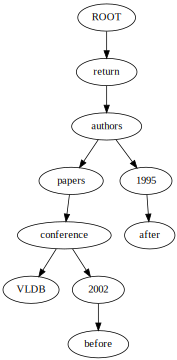

In [8]:
query.parse_tree.show()

##  Entity Resolution

Esse módulo é a primeira fase do **Tree Strucutre Adjustor**. Antes de gerar as árvores, seguindo a gramática, **Entity Resolution** verifica quais nós referenciam o mesmo atributo na consulta. Essa relação é utilizada tanto na geração de árvores derivadas, quanto na pontuação das árvores. Segue abaixo o código da função ``entity_resolute``, seguido da saída da mesma: 


``` python 

def entity_resolute(query):
    query.entities = []
    nodes = query.parse_tree.all_nodes
    for i in range(len(nodes)):
        left = nodes[i]
        if left.get_choice_map() == None:
            continue
        left_map = left.get_choice_map().schema_element
        for j in range(i+1, len(nodes)):
            right = nodes[j]
            if right.get_choice_map() == None:
                continue
            right_map = right.get_choice_map().schema_element
            if left_map == right_map:
                if left.token_type == "VTTEXT" and left.token_type == "VTTEXT":
                    if left.label == right.label:
                        entity_pair = EntityPair(left, right)
                        query.entities.append(entity_pair)
                    else:
                        continue
                if left.token_type == "VTTEXT" and right.token_type == "NT" or\
                 left.token_type == "NT" and right.token_type == "VTTEXT" or\
                 left.token_type == "NT" and right.token_type == "NT":
                    if abs(left.word_order - right.word_order) > 2:
                        continue
                    else:
                        entity_pair = EntityPair(left, right)
                        query.entities.append(entity_pair)

```

In [9]:
entity_resolute(query)
query.entities

[EntityPair('(11)VLDB', '(9)conference')]

## Tree Structure Adjustor

Este módulo é responsável por:
 * Verificar se a árvore gerada condiz com a gramática especificada
 * Gerar Árvores variantes da Árvore de Parser Original que seguem a gramática
 * Ranquear todas as Árvores, e escolher a com maior pontuação para a etapa de tradução.
 
A gramática que deve ser seguida para as árvores é a seguinte:
```

Q -> (SClause)(ComplexCondition)*
SClause -> SELECT + GNT
ComplexCondition -> ON + (leftSubtree*rightSubtree)
leftSubtree -> GNP
rightSubtree -> GNP |VN | MIN | MAX
GNP -> (FN + GNP) | NP
NP -> NN + (NN)*(Condition)*
Condition-> VN | (ON + VN)
```

Em que: 
* VN, NN, FN, ON são tipos de nós referenciados na [tabela de tipos de nós](#tipo_no)
* `+` representa relações de pai-filho entre os nós
* `*` representa relações de irmão entre os nós


A função `tree_structure_adjust`, listada a seguir, é a responsável por executar o processo de geração das árvores.

``` python
    	def tree_structure_adjust(query,  db):
		query.adjusting_trees = []
		query.invalid = []
		pre_trees = {}
   
		TreeStructureAdjustor.adjust(query, db,False, pre_trees)
		if len(query.adjusting_trees) == 0 or (len(query.adjusting_trees) > 0 and query.adjusting_trees[0].cost > 3):
			max_min = False
			for node in query.parse_tree.all_nodes:
				if node.function == 'max' or node.function == 'min':
					max_min = True
					break

			if max_min:
				TreeStructureAdjustor.adjust(query, db, True, pre_trees)

		adjusted_trees = query.adjusting_trees
		adjusted_trees.sort(key=lambda elem : ((elem.weight * 100) - elem.cost) * -1 )
		for i  in range(len(adjusted_trees)):
			adjusted_tree = adjusted_trees[i]

			for j in range(len(adjusted_tree.all_nodes)):
				node = adjusted_trees[i].all_nodes[j]
				node.children.sort(key=lambda elem: elem.node_id)
			hash(adjusted_tree)


		linked_list = []
		i = 0
		while i  < len(adjusted_trees):
			if adjusted_trees[i].hash_num in linked_list:
				adjusted_trees.pop(i)
				i-=1
			else:
				linked_list += [adjusted_trees[i].hash_num]
			i+=1

		TreeStructureAdjustor.build_adjusted_trees(query)


```


Como podemos observar, primeiramente é gerado uma série de árvores, chamadas `adjusting_trees`. Depois de ordenarmos estas árvores intermediárias, ordenamos todos os filhos de todos os nós, e retiramos as árvores repetidas da lista. A partir dai, geramos a lista final de árvores, no método `build_adjusted_trees`. A seguir, verificamos a saída final do método.

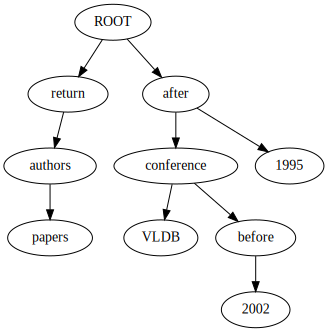

In [10]:
TreeStructureAdjustor.tree_structure_adjust(query,rdbms)
query.query_tree.show()

## SQL Translator

O último módulo da arquitetura do NaLIR, é responsável por receber a query_tree, gerada pelo **Query Tree Strucutre Adjustor** e retornar a SQL correspondente.  A função `translate`, listada a seguir, é a responsável por executar esse processo dentro do módulo. 

Como vemos no código a estrutura utilizada para converter a árvore em uma string SQL é uma estrutura chamada `block`. Cada `block` identifica um nivel de consulta. Assim, consultas que não possuem subconsultas, possuem apenas um bloco. Consultas que possuem agregação, ou consultas aninhadas, possuem dois ou mais blocos.

```python
def translate(query, db):
    pre_structure_adjustor(query)
    if len(query.query_tree.all_nodes) < 2:
        return
    query.blocks = []
    block_split(query)
    query.blocks[0].node_edge_gen(query.main_block, query.query_tree, query.graph)
    query.blocks[0].translate(query.main_block, query.query_tree)
    query.translated_sql = query.blocks[0].sql
```

In [12]:
translate(query, rdbms)
print(query.translated_sql)

ERROR:/home/pr3martins/nalir-sbbd/nalir/data_structure/block.py:Error by choice none


SELECT DISTINCT author.name, block_1.count
FROM publication, author, writes, (SELECT count(conference.name) as count, author.name FROM conference, author, publication, writes WHERE conference.name = "VLDB" AND publication.year < 2002 AND conference.cid = publication.cid AND publication.pid = writes.pid AND writes.aid = author.aid AND conference.cid = publication.cid) block_1
WHERE block_1.count > 1995 AND publication.title = "Papers" AND author.name = block_1.name AND author.aid = writes.aid AND writes.pid = publication.pid


## Outras consultas que também podem ser executadas

In [ ]:
queries = [
    'return me the homepage of PVLDB.',
    'return me the homepage of "H. V. Jagadish".',
    'return me the abstract of "Making database systems usable".',
    'return me the year of "Making database systems usable"',
    'return me all the keywords.',
    'return me the number of the organizations in "North America".',
    'return me the number of keywords in VLDB conference.',
    'return me the number of the organizations.',
    'return me the paper in Databases area with more than 200 citations.',
]

sql_queries = []
for query in queries:
    sql_query = run_query(query)
    sql_queries += [sql_query]